In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from sklearn.cluster import MiniBatchKMeans

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
])
train_set = datasets.MNIST(root='data/', download=True, transform=transform, train=True)
test_set = datasets.MNIST(root='data/', download=True, transform=transform, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
model = torchvision.models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.fc = nn.Identity()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

In [6]:
k_means = MiniBatchKMeans(n_clusters=64, batch_size=batch_size)

In [7]:
model.eval()

with torch.no_grad():
  for x, y in train_loader:
    x = x.to(device)
    output = model(x)
    k_means.partial_fit(np.array(output.cpu()))

In [8]:
predictions = []
model.eval()

with torch.no_grad():
  for x, y in test_loader:
    x = x.to(device)
    output = model(x)
    predictions.append(k_means.predict(np.array(output.cpu())))

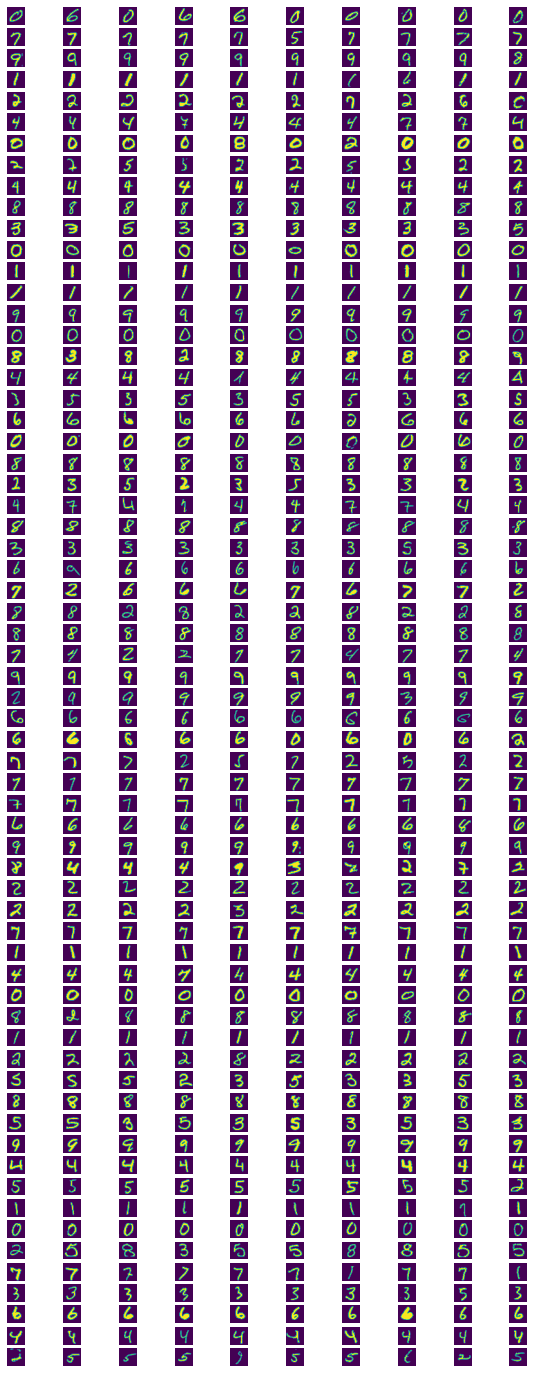

In [55]:
predictions = np.array(predictions).reshape((1, 10000))
fig = plt.figure(figsize=(10, 25))
fig.subplots_adjust(wspace=0.0001, hspace=0.2)
for i in range(0, 64):
  indices = np.where(predictions == i)[1]
  np.random.shuffle(indices)
  for j, image in enumerate(test_set.data[indices[0:10]]):
    fig.add_subplot(64, 10, i * 10 + j + 1)
    plt.axis('off')
    plt.imshow(image)